In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 3.5 MB/s eta 0:00:00


In [2]:
pip install pymc==5.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.1/469.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.18.6
    Uninstalling pytensor-2.18.6:
      Successfully uninstalled pytensor-2.18.6
  Attempting uninstall: pymc
    Found existing installation: pymc 5.10.4
    Uninstalling pymc-5.10.4:
      Successfully uninstalled pymc-5.10.4


In [3]:
pip show numba

Name: numba
Version: 0.58.1
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: llvmlite, numpy
Required-by: cudf-cu12, librosa, rmm-cu12


In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from scipy.stats import probplot

import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import graphviz

In [5]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

Mounted at /drive


In [6]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20))

del raw22
del raw21
del raw20
del raw23

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles. It seems intuitive to remove angles greater than 45 degrees for the foul line.
#However, I only have balls in play in my dataset, and yet there are a lot of balls with angles greater than 45 degrees.
#I don't know if that is bad measurements or an effect of the wind or what, but if I cut off the angles too soon, when I go
#to fit the beta dists, I get really steep lines at 0 and 1, like undefined slopes almost, which messes up the advi optimizer,
#so it works better if I cut it off at 55 and then when I go to sample batted balls to optimize for positioning, I will remove batted
#balls from the sample that land at an angle greater than 45 because those are foul.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'hd']]

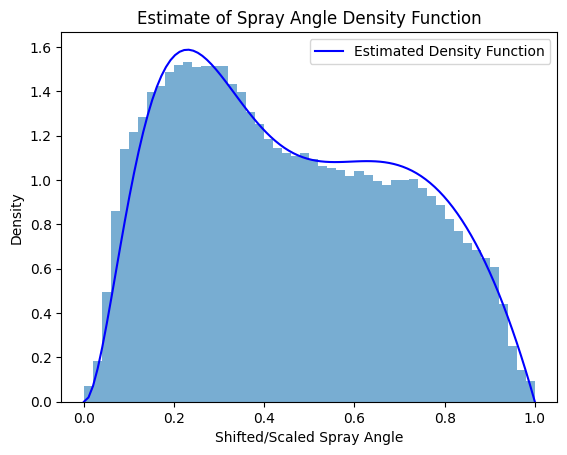

In [8]:
plt.hist(all_data.hd.values, density = True, bins = 50, alpha = 0.6)
x = np.linspace(0,1,100)
plt.plot(x, .4*beta(a = 3, b=9).pdf(x)+ 0.6*beta(a=3,b=2).pdf(x), 'b-', label = 'Estimated Density Function')
plt.legend()
plt.xlabel('Shifted/Scaled Spray Angle')
plt.ylabel('Density')
plt.title('Estimate of Spray Angle Density Function')
plt.show()

In [ ]:
#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

all_data = all_data.merge(batter_indices, on = 'batter_id_hand')

#train test split on 2023
train = all_data.loc[all_data.game_year < 2023]
test = all_data.loc[all_data.game_year == 2023]

I didn't do it here, but you may need to remove players in the training data that aren't also in the test set.

### Model: mixture of betas

In [ ]:
#for the prior for the weights, I'm just going to go with dirichlet([0.4,0.6]), so just use the exact probabilities I found in the exploratory notebook.
#for the priors for the alpha and beta parameters in the beta distributions, I want them to have mean of [3,3] for alpha and [9,2] for beta based on
#what I found in the exploratory notebook, but I don't know what to do with variance. So I am just going to try to match the variance I had in the
#hit direction 1 notebook, which was about 0.024 and 0.027 for alpha and beta repsectively. I'll go a little bit bigger than that to be safe, 0.03 and 0.03
weight_prior_alpha = np.array([0.4, 0.6])
alpha_prior_mean = np.array([3,3])
alpha_prior_var = np.array([0.03,0.03])
beta_prior_mean = np.array([9,2])
beta_prior_var = np.array([0.03,0.03])

In [ ]:
n_batters = len(train.batter_index.unique())
nclusters = 2
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'clusters': [1,2]}

with pm.Model(coords = coords) as mod1:

    ####hyperpriors
    #gamma dist for the prior for the alpha in the dirichlet distribution. Gamma will ensure that we don't get any nonpositive values
    weight_alpha_prior = pm.Gamma('weight_alpha_prior', mu = np.array([4,6]), sigma = np.array([10,10]))

    #gamma dist for the prior for the mean in the batter alphas and batter betas. This ensures positive means
    alpha_mu_prior = pm.Gamma('alpha_mu_prior', mu = np.array([3,3]), sigma = np.array([10,10]))
    beta_mu_prior = pm.Gamma('beta_mu_prior', mu = np.array([9,2]), sigma = np.array([10,10]))

    #half normals for the sigma priors
    alpha_sigma_prior = pm.HalfNormal('alpha_sigma_prior', sigma = np.ones(nclusters))
    beta_sigma_prior = pm.HalfNormal('beta_sigma_prior', sigma = np.ones(nclusters))

    #### batter specific beta dists
    #prior for the alpha parameter in the beta dists
    batteralphas = pm.Gamma('batteralphas', mu = alpha_mu_prior, sigma = alpha_sigma_prior, dims = ('batter', 'clusters'))

    #prior for the beta parameter in the beta dists
    batterbetas = pm.Gamma('batterbetas', mu = beta_mu_prior, sigma = beta_sigma_prior, dims = ('batter', 'clusters'))

    #the batter weights have a prior of dirichlet(alpha_prior)
    batterweights = pm.Dirichlet('batterweights', a = weight_alpha_prior, dims = ('batter', 'clusters'))

    b = pm.Data("b", train.batter_index.values, dims = 'observation')
    x = pm.Data('x', train.hd.values, dims = 'observation')

    #each observation is distributed as a mixture of betas with alpha given by batter_alphas, beta given by batterbetas, and weights given by the batter weights.
    bets = pm.Beta.dist(alpha = batteralphas[b], beta = batterbetas[b], shape = (train.shape[0],2))
    likelihood = pm.Mixture('likelihood', w= batterweights[b], comp_dists = bets, observed = x, dims = 'observation')

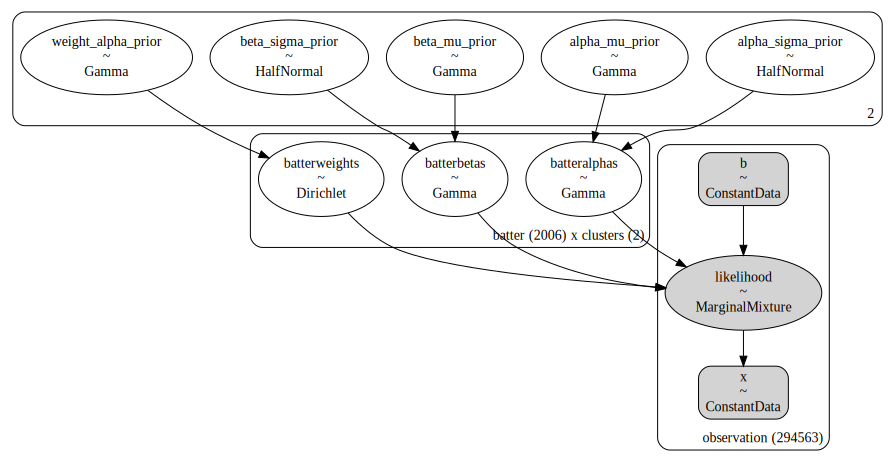

In [ ]:
graph = pm.model_to_graphviz(mod1)
graph

In [ ]:
with mod1:
    inference = pm.ADVI()
    approx = pm.fit(n=20000, method = inference)

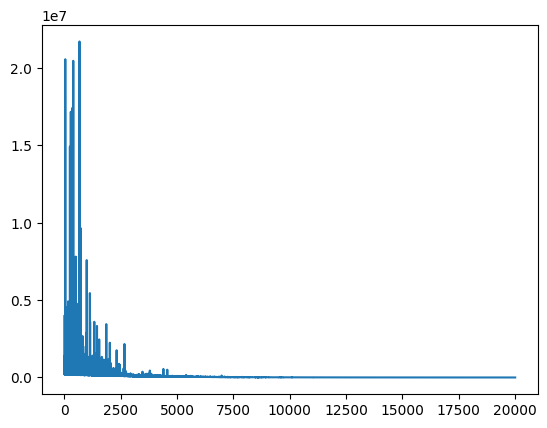

In [ ]:
plt.plot(inference.hist, label = 'advi')
plt.show()
trace = approx.sample(2000)

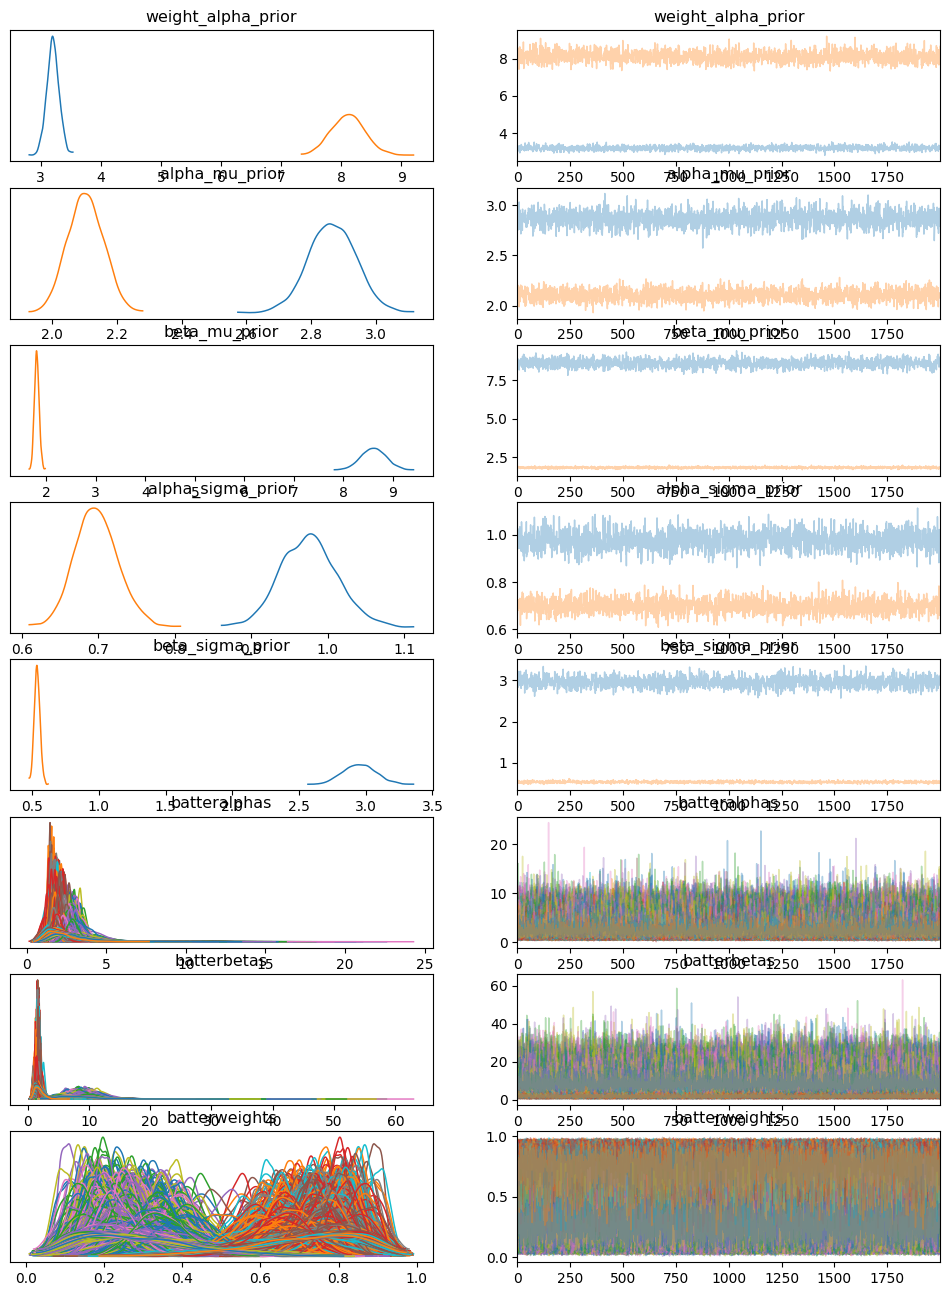

In [ ]:
az.plot_trace(trace)
plt.show()

That was a lot slower than I remember so I'm going to save the results now if I ever need to redo the plots or the tests below.

In [ ]:
balphas = trace.posterior.batteralphas.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_alpha1', 'batter_alpha2']] = balphas
bbs = trace.posterior.batterbetas.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_beta1', 'batter_beta2']] = bbs
bweights = trace.posterior.batterweights.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_w1', 'batter_w2']] = bweights
batter_indices.to_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/hit_direction/hd_dists_sloan_version_testing.csv', index=False)

In [ ]:
batter_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/hit_direction/hd_dists_sloan_version_testing.csv')

In [ ]:
train = train.merge(batter_indices[['batter_id_hand', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2']], on = 'batter_id_hand')
test = test.merge(batter_indices[['batter_id_hand', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2']], on = 'batter_id_hand')

In [ ]:
train['log_like'] = np.log(train.batter_w1.values * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).pdf(train.hd.values) + train.batter_w2.values * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).pdf(train.hd.values))
test['log_like'] = np.log(test.batter_w1.values * beta(a = test.batter_alpha1.values, b = test.batter_beta1.values).pdf(test.hd.values) + test.batter_w2.values * beta(a = test.batter_alpha2.values, b = test.batter_beta2.values).pdf(test.hd.values))
train.log_like.mean(), test.log_like.mean()

(0.10795715300777539, 0.10375524055699693)

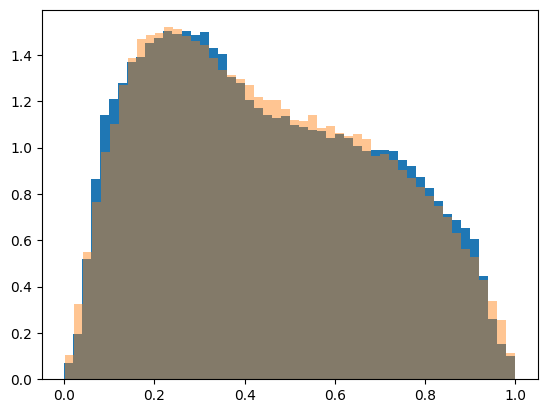

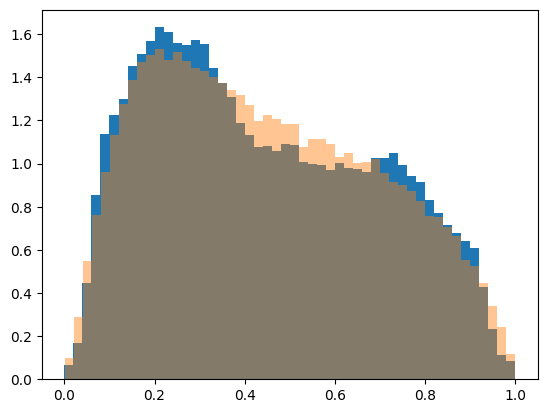

In [ ]:
#draw a sample for each hd in train
choice = np.random.binomial(1, train.batter_w1.values, size = train.shape[0])
samp = choice * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).rvs() + (1-choice) * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).rvs()
plt.hist(train.hd.values, density = True, bins = 50)
plt.hist(samp, density = True, bins = 50, alpha = 0.45)
plt.show()

#test
choice = np.random.binomial(1, test.batter_w1.values, size = test.shape[0])
samp = choice * beta(a = test.batter_alpha1.values, b = test.batter_beta1.values).rvs() + (1-choice) * beta(a = test.batter_alpha2.values, b = test.batter_beta2.values).rvs()
plt.hist(test.hd.values, density = True, bins = 50)
plt.hist(samp, density = True, bins = 50, alpha = 0.45)
plt.show()

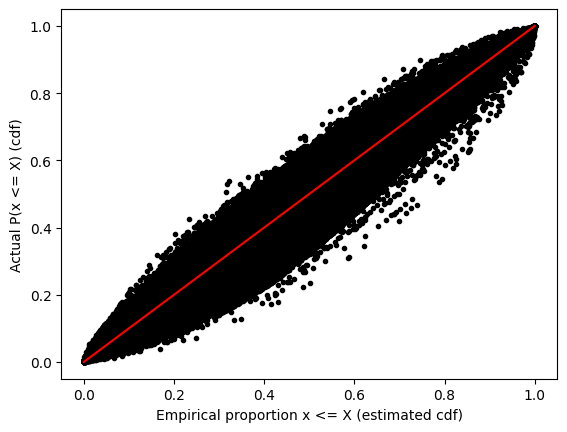

In [ ]:
def pp_plot2(weights, alphas, betas, data):
    cdf_estimate = np.array([np.mean(i >= data) for i in data])
    cdf_actual = weights[0] * beta(a = alphas[0], b = betas[0]).cdf(data) + weights[1]* beta(a = alphas[1], b = betas[1]).cdf(data)
    plt.plot(cdf_estimate, cdf_actual, 'k.')
    plt.plot(np.sort(cdf_actual), np.sort(cdf_actual), 'r-')
    plt.xlabel('Empirical proportion x <= X (estimated cdf)')
    plt.ylabel('Actual P(x <= X) (cdf)')
    plt.show()

pp_plot2(np.vstack((train.batter_w1.values, train.batter_w2.values)), np.vstack((train.batter_alpha1.values, train.batter_alpha2.values)), np.vstack((train.batter_beta1.values, train.batter_beta2.values)), train.hd.values)

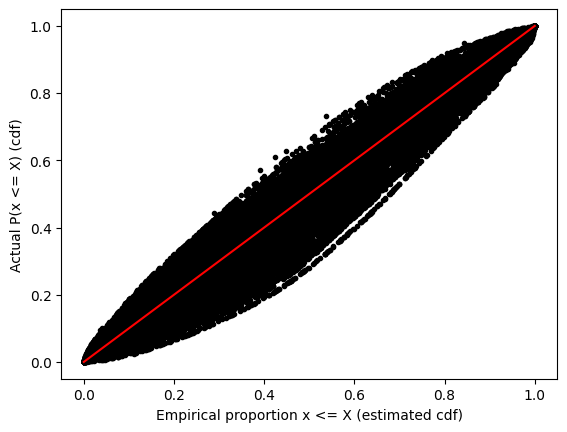

In [ ]:
pp_plot2(np.vstack((test.batter_w1.values, test.batter_w2.values)), np.vstack((test.batter_alpha1.values, test.batter_alpha2.values)), np.vstack((test.batter_beta1.values, test.batter_beta2.values)), test.hd.values)

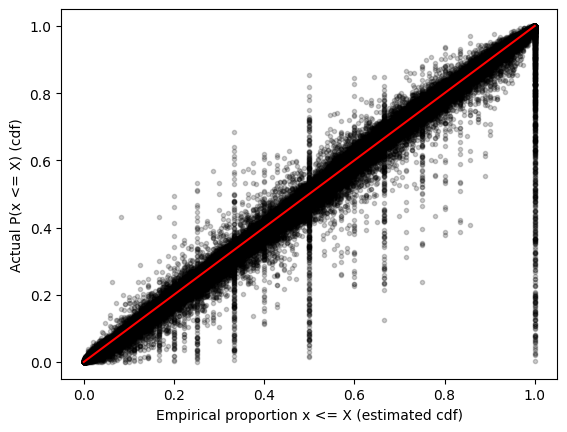

In [ ]:
def pp_plot3(dataframe):
    for b in dataframe.batter_index.unique():
        data = dataframe.loc[dataframe.batter_index == b]
        cdf_estimate = np.array([np.mean(i >= data.hd.values) for i in data.hd.values])
        m1 = data.batter_alpha1.values[0]
        m2 = data.batter_alpha2.values[0]
        s1 = data.batter_beta1.values[0]
        s2 = data.batter_beta2.values[0]
        w1 = data.batter_w1.values[0]
        w2 = data.batter_w2.values[0]
        cdf_actual = w1 * beta(a=m1,b=s1).cdf(data.hd.values) + w2* beta(a=m2,b=s2).cdf(data.hd.values)
        plt.plot(cdf_estimate, cdf_actual, 'k.', alpha = 0.2)
    plt.plot([0,1],[0,1], 'r-')
    plt.xlabel('Empirical proportion x <= X (estimated cdf)')
    plt.ylabel('Actual P(x <= X) (cdf)')
    plt.show()

pp_plot3(train)

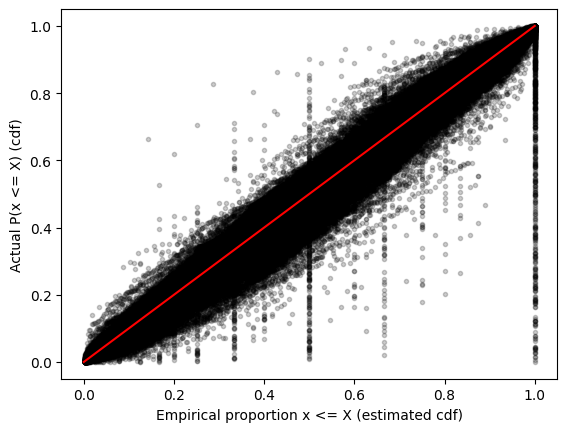

In [ ]:
pp_plot3(test)